<a href="https://colab.research.google.com/github/first-penguin-hub/rabbit_challenge/blob/main/4_2_wide_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なライブラリの読み込み

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# データの取得

`tf_flowers` データセットを今回は使用する。

In [2]:
tf_flowers = tfds.image_classification.TFFlowers()
tf_flowers.download_and_prepare()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
(train_ds, test_ds) = tf_flowers.as_dataset(as_supervised=True, split=['train[:70%]', 'train[70%:]'], shuffle_files=True)

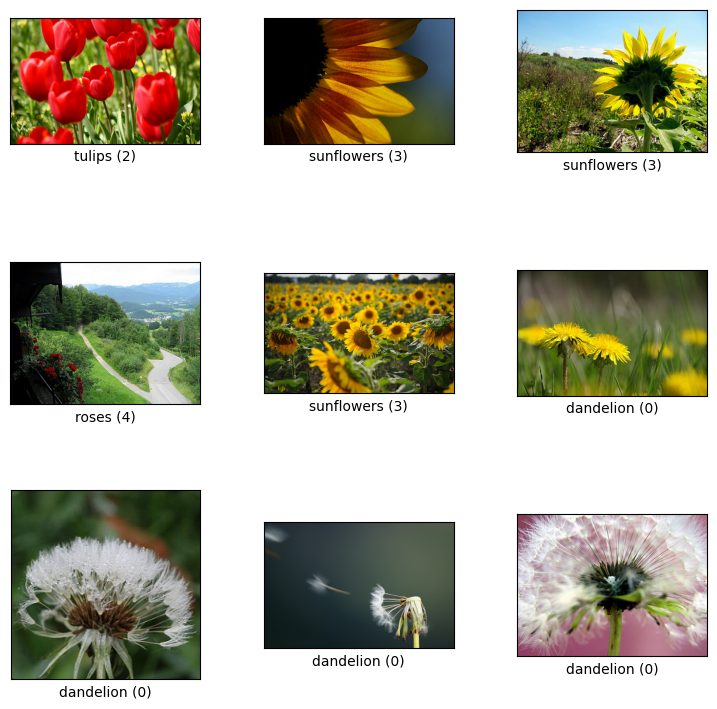

In [4]:
fig = tfds.show_examples(train_ds, tf_flowers.info)

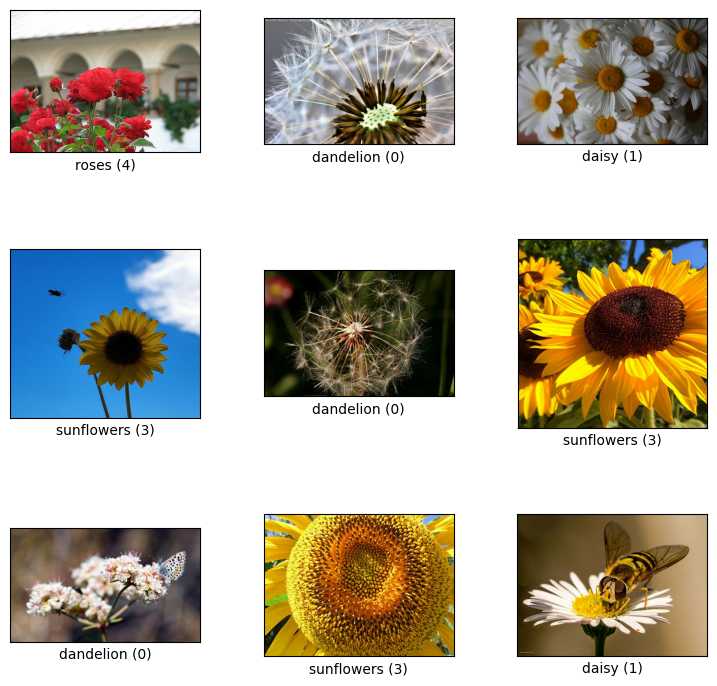

In [5]:
fig = tfds.show_examples(test_ds, tf_flowers.info)

In [6]:
class_num = tf_flowers.info.features['label'].num_classes
class_num

5

In [7]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    label = tf.one_hot(label, depth=class_num)

    return image, label

BATCH_SIZE = 16

train_batches = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(test_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


学習結果を記録する。

In [8]:
histories = []

エポック数20回で学習を実行。

In [9]:
EPOCHS = 20

## ResNetの例

### 転移学習 (Weightを再利用、事前学習部分のWeightは固定)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5", trainable=False),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


In [11]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_batches,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
    ]
)
histories.append(history)

Epoch 1/20
161/161 [==============================] - 27s 74ms/step - loss: 0.5974 - acc: 0.7844 - val_loss: 0.3706 - val_acc: 0.8819
Epoch 2/20
161/161 [==============================] - 12s 74ms/step - loss: 0.2577 - acc: 0.9175 - val_loss: 0.3221 - val_acc: 0.8910
Epoch 3/20
161/161 [==============================] - 9s 58ms/step - loss: 0.1744 - acc: 0.9506 - val_loss: 0.2985 - val_acc: 0.8974
Epoch 4/20
161/161 [==============================] - 9s 59ms/step - loss: 0.1297 - acc: 0.9712 - val_loss: 0.2852 - val_acc: 0.9019
Epoch 5/20
161/161 [==============================] - 12s 72ms/step - loss: 0.1014 - acc: 0.9801 - val_loss: 0.2791 - val_acc: 0.9046
Epoch 6/20
161/161 [==============================] - 13s 78ms/step - loss: 0.0823 - acc: 0.9852 - val_loss: 0.2761 - val_acc: 0.9046
Epoch 7/20
161/161 [==============================] - 9s 58ms/step - loss: 0.0678 - acc: 0.9887 - val_loss: 0.2746 - val_acc: 0.9074
Epoch 8/20
161/161 [==============================] - 12s 73ms/st

### ファインチューニング (事前学習部分のWeightも再調整)

ResNetには、BatchNorm層が存在する。

ファインチューニングで、ResNetの部分の重みを再調整する場合でも、BatchNorm層に存在する平均や分散の値は更新しない。

そのため、`Non-trainable params`が存在する。

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5", trainable=True),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,571,397
Trainable params: 23,518,277
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_batches,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
    ]
)
histories.append(history)

Epoch 1/20
161/161 [==============================] - 69s 207ms/step - loss: 1.3448 - acc: 0.6275 - val_loss: 52.8263 - val_acc: 0.3279
Epoch 2/20
161/161 [==============================] - 29s 179ms/step - loss: 0.9626 - acc: 0.7696 - val_loss: 2.6921 - val_acc: 0.5377
Epoch 3/20
161/161 [==============================] - 29s 178ms/step - loss: 0.8092 - acc: 0.8221 - val_loss: 1.0548 - val_acc: 0.7293
Epoch 4/20
161/161 [==============================] - 31s 194ms/step - loss: 0.6836 - acc: 0.8649 - val_loss: 10.0067 - val_acc: 0.3460
Epoch 5/20
161/161 [==============================] - 31s 192ms/step - loss: 0.6218 - acc: 0.8980 - val_loss: 2.0302 - val_acc: 0.6058


## WideResNetの例

次の2つの例では、WideResNetの構造を用いた、

### 転移学習 (Weightを再利用、事前学習部分のWeightは固定)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x3/1", trainable=False),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 6144)              211174080 
                                                                 
 dense_2 (Dense)             (None, 5)                 30725     
                                                                 
Total params: 211,204,805
Trainable params: 30,725
Non-trainable params: 211,174,080
_________________________________________________________________


In [15]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_batches,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
    ]
)
histories.append(history)

Epoch 1/20
161/161 [==============================] - 143s 783ms/step - loss: 0.8811 - acc: 0.7030 - val_loss: 0.5083 - val_acc: 0.8465
Epoch 2/20
161/161 [==============================] - 121s 754ms/step - loss: 0.4133 - acc: 0.8852 - val_loss: 0.3678 - val_acc: 0.8892
Epoch 3/20
161/161 [==============================] - 114s 712ms/step - loss: 0.3133 - acc: 0.9116 - val_loss: 0.3127 - val_acc: 0.9019
Epoch 4/20
161/161 [==============================] - 121s 753ms/step - loss: 0.2627 - acc: 0.9299 - val_loss: 0.2823 - val_acc: 0.9064
Epoch 5/20
161/161 [==============================] - 121s 754ms/step - loss: 0.2296 - acc: 0.9369 - val_loss: 0.2625 - val_acc: 0.9110
Epoch 6/20
161/161 [==============================] - 122s 757ms/step - loss: 0.2050 - acc: 0.9420 - val_loss: 0.2485 - val_acc: 0.9128
Epoch 7/20
161/161 [==============================] - 114s 712ms/step - loss: 0.1854 - acc: 0.9490 - val_loss: 0.2379 - val_acc: 0.9164
Epoch 8/20
161/161 [============================

### ファインチューニング (事前学習部分のWeightも再調整)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x3/1", trainable=True),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc']) # learning_rateを調整しています。
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 6144)              211174080 
                                                                 
 dense_3 (Dense)             (None, 5)                 30725     
                                                                 
Total params: 211,204,805
Trainable params: 211,204,805
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_batches,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
    ]
)
histories.append(history)

Epoch 1/20
161/161 [==============================] - 349s 2s/step - loss: 0.3269 - acc: 0.8891 - val_loss: 0.1276 - val_acc: 0.9519
Epoch 2/20
161/161 [==============================] - 288s 2s/step - loss: 0.0334 - acc: 0.9914 - val_loss: 0.1049 - val_acc: 0.9655
Epoch 3/20
161/161 [==============================] - 295s 2s/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.1048 - val_acc: 0.9655
Epoch 4/20
161/161 [==============================] - 288s 2s/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.1019 - val_acc: 0.9664
Epoch 5/20
161/161 [==============================] - 295s 2s/step - loss: 0.0022 - acc: 0.9992 - val_loss: 0.1033 - val_acc: 0.9664
Epoch 6/20
161/161 [==============================] - 295s 2s/step - loss: 0.0019 - acc: 0.9992 - val_loss: 0.1037 - val_acc: 0.9664


In [18]:
histories

<Axes: xlabel='Epochs', ylabel='acc'>

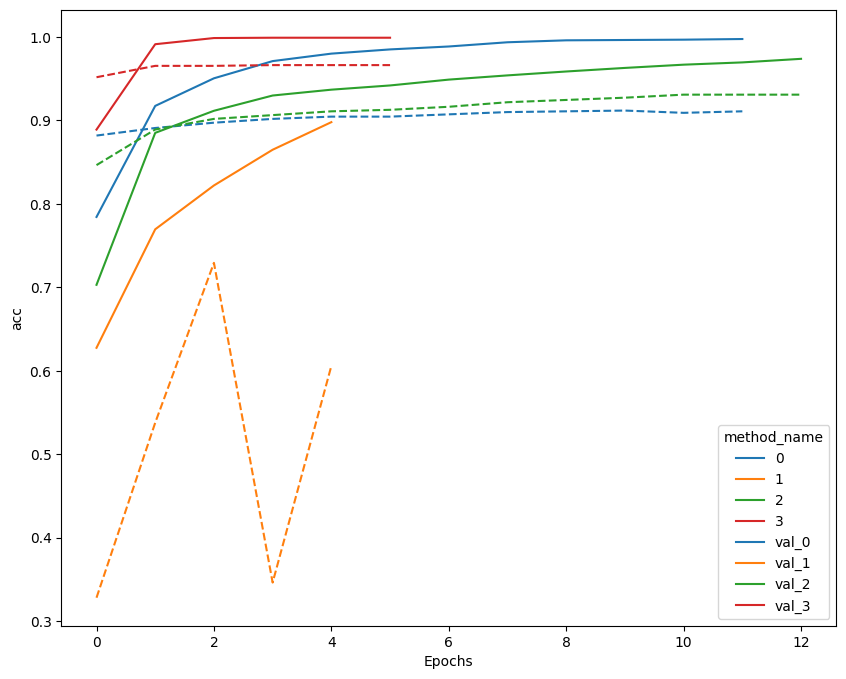

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
method_names = [
  'ResNet Transfer lerning',
  'ResNet Fine-Tune',
  'ResNetWide Transfer lerning',
  'ResNetWide Fine-Tune',
]

plot_df = pd.DataFrame()

for i, history in enumerate(histories):
    # method_name = str(method_names[i])
    method_name = str(i)
    history_df = pd.DataFrame(history.history)
    history_df['method_name'] = method_name
    history_df['Epochs'] = history_df.index
    plot_df = pd.concat([plot_df, history_df], ignore_index=True)

sns.lineplot(data=plot_df, x=plot_df['Epochs'], y='acc', hue='method_name')
val_plot_df = plot_df
val_plot_df['method_name'] = plot_df['method_name'].apply(lambda x: 'val_' + x)
sns.lineplot(data=val_plot_df, x=plot_df['Epochs'], y='val_acc', hue='method_name', linestyle='dashed')